# Mount Drive and Install FPZIP

In [ ]:
# Importing gdrive from colab
from google.colab import drive
# mounting the drive
drive.mount('/content/drive', force_remount=True)
# Install the fpzip for floating point compression(Entropy Encoder)
!pip install fpzip

Mounted at /content/drive


#Initialisations

In [ ]:
import numpy as np # python library for Arrays, Math functions, Linear algebra, statistics
import matplotlib.pyplot as plt # python library for plotting
import matplotlib.image as mpimg # python library for image processing
import tensorflow as tf # ML framework to build neural network
from tensorflow import keras # Keras API that uses tensorflow in backend
from keras.api.layers import *
from keras.api.models import Model
import fpzip # we have not build it from cmake and makefile user the wrapper in python
import time # python library for time related functions
import math
import os # library to handle os related functions in platform independent manner


epochs = 5 # 50 (max) -> (depends)
batch_size1 = 64 #32 default
fc = 2048 # no of neurons in hidden layer before the latent layer
P =  1024 # no of neurons in LATENT layer till now its not fixed

#Resource Data

In [ ]:
start_time = time.time() # stores the starting time
f = open('/content/drive/My Drive/SEQ3.txt','r') # open the file in read mode ('r')
seq = f.read() # giving read() instead of readline() # reads the entire file
f.close() # closing the file pointer
seq_len = len(seq)
print(seq_len)
print('Read_time:',time.time()-start_time) # measure the end time

10000000
Read_time: 0.04240298271179199


#Data Replace and Reshape

In [ ]:
content = seq.translate(str.maketrans('ATCG', '1234')) # creates a translation table and applies the translation to the seq.

k=128  #chunk size defined 8 for our small dataset but generally 128 and for higher files 256(but it consumes more RAM)
chunk_shape = (k,k,5) # (128, 128, 5) -> 5 for 5 classes [PAD,A,T,C,G]
content_size=len(content)
chunk_size = k*k # (128 x 128) i.e 16384

pad_len = chunk_size - (content_size%chunk_size) # no of padding needed to make multiple of chunk_size so that each chunk becomes a square matrix

#padding
content_array = content.ljust(content_size+pad_len,'0') # It pads the string with ('0') on the right side until it reaches the size of content+padlen, so that its length becomes a multiple of the chunk size.

print(len(content_array))

content_padsize = len(content_array) # size after padding
row = content_padsize//chunk_size # no. of rows

content_array = np.frombuffer(content_array.encode('ascii'), dtype=np.uint8) - ord('0') # "1234" -> b'1234' -> bytes[49,50,51,52] -> array([49,50,51,52]) -> array([1,2,3,4])

content_array1 = np.zeros((content_array.size,5),dtype=np.uint8) # | One hot Encoding
content_array1[np.arange(content_array.size),content_array] = 1  # |    of class 5
print(content_array1.shape)

content_array = content_array1.reshape(-1,k,k,5) # reshaping the array in a 4D tensor for CNN with a shape - (no.of_chunks, 128, 128, 5) i.e no.of_chunks no of matrix(image) each of size 128 x 128 where each pixel has 5 channels.
print(content_array.shape)


10010624
(10010624, 5)
(611, 128, 128, 5)


#Train and Validation Data Splitting

In [ ]:
val_split = 0.1  # 10% for validation
val_size = int(row * val_split)
train_size = row - val_size

# Slices for manual split
train_array = content_array[:train_size] # 90% for training
val_array = content_array[train_size:] # 10% for validating

def ram_generator_train():
    for i in range(train_size):
        chunk = train_array[i].astype(np.float32) # iterates through each chunk and convert them into float32
        yield chunk, chunk # instead of returning the whole chunk at a time, it yields each chunk while iterating so memory efficient.

def ram_generator_val():
    for i in range(val_size):
        chunk = val_array[i].astype(np.float32)
        yield chunk, chunk # chunk, chunk -> input and target are same

train_dataset = tf.data.Dataset.from_generator( # from_generator creates the dataset from ram_generator_.. with a certain batchsize
    ram_generator_train,
    output_signature=(
        tf.TensorSpec(shape=(k, k, 5), dtype=tf.float32),
        tf.TensorSpec(shape=(k, k, 5), dtype=tf.float32)
    )
).batch(batch_size1).prefetch(tf.data.AUTOTUNE)  # prefetch optimal amount of batches in the background while current one is processing by AUTOTUNE

val_dataset = tf.data.Dataset.from_generator(
    ram_generator_val,
    output_signature=(
        tf.TensorSpec(shape=(k, k, 5), dtype=tf.float32), # specifies the shape and dtype of the o/p yielded by ram_generator of TF
        tf.TensorSpec(shape=(k, k, 5), dtype=tf.float32)
    )
).batch(batch_size1).prefetch(tf.data.AUTOTUNE)

#Model CNN - Encoder

In [ ]:
inputs = Input(shape=chunk_shape) # Input(chunk_shape) is passed through the layers below

# 1st Convolution
c1 = Conv2D(filters=32,kernel_size=(3,3),padding='same')(inputs) #conv2D layer with 32 filters of size 3x3
c1 = BatchNormalization()(c1)
c1 = LeakyReLU()(c1) # activation func.(ReLU) but it prevents "dead neurons"
p1 = MaxPool2D((2,2),padding='same')(c1) # reduces spatial size by half(downsampling)
p1 = Dropout(0.25)(p1) # randomly drops 25% of neurons to prevent overfitting
# 2nd convolution
c2 = Conv2D(filters=64,kernel_size=(3,3),padding='same')(p1) # conv2D layer with 64 filters of size 3x3
c2 = BatchNormalization()(c2)
c2 = LeakyReLU()(c2)
p2 = MaxPool2D((2,2),padding='same')(c2)
p2 = Dropout(0.25)(p2)
# 3rd Convolution
c3 = Conv2D(filters=128,kernel_size=(3,3),padding='same')(p2)
c3 = BatchNormalization()(c3) # conv2D layer with 128 filters to capture higher level features
c3 = LeakyReLU()(c3)
p3 = MaxPool2D((2,2),padding='same')(c3)
p3 = Dropout(0.25)(p3)

# Flatten
flat = Flatten()(p3) # flattens the 3D feature map to a 1D vector which is required for dense layer
flat_dim = flat.shape[1] # storing the postflatten dimension

# Hidden layers
d1 = Dense(units=fc*2,activation='relu')(flat) # dense layer with 4096 no of neurons
d1 = Dropout(0.5)(d1)

d2 = Dense(units=fc,activation='relu')(d1) # dense layer with 2048 no of neurons
d2 = Dropout(0.5)(d2)
d2 = BatchNormalization()(d2)

# Bottleneck layer
latent = Dense(units=P,activation='relu',name = 'latent_space')(d2) # bottleneck layer(latent_space) with 1024 no of neurons

encoder = Model(inputs=inputs,outputs=[latent,c1,c2,c3]) # defining the model of encoder which takes chunks as input and gives output of latent layer and intermediate conv layers for skip connection
encoder.summary() # gives an overview of the proposed model

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 128, 128, 5)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 128, 128, 32)   │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4096)           │   134,221,824 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2048)           │     8,390,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 2048)           │         8,192 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ latent_space (Dense)            │ (None, 1024)           │     2,098,17

 Total params: 144,813,568 (552.42 MB)

 Trainable params: 144,809,024 (552.40 MB)

 Non-trainable params: 4,544 (17.75 KB)

#Model CNN - Decoder

In [ ]:
latent_input = Input(shape=(P,)) # Input for the decoder which is the latent_space obtained from encoder

# additional inputs to be given to the decoder for more spatial details
skip1 = Input(shape=c1.shape[1:],name='skip_c1') # c1: output of the 1st Conv block
skip2 = Input(shape=c2.shape[1:],name='skip_c2') # c2: output of the 2nd Conv Block
skip3 = Input(shape=c3.shape[1:],name='skip_c3') # c3: output of the 3rd Conv Block

dec_flat = Dense(units=flat_dim,activation='relu')(latent_input) # dense layer to get back the input shape after flatten
dec_flat = BatchNormalization()(dec_flat)
reshaped = Reshape((p3.shape[1],p3.shape[2],p3.shape[3]))(dec_flat) # reshaping the flattend vector to the shape of p3 layer to restore the exact spatial shape that the encoder had before flattening

# 1st Conv Transpose layer
u1 = Conv2DTranspose(filters=128,kernel_size=(3,3),strides=(2,2),padding='same')(reshaped) # transpose convolution to increase the spatial resolution i.e upsampling (reverse of MaxPool2D)
u1 = BatchNormalization()(u1)
u1 = LeakyReLU()(u1)
u1 = Concatenate()([u1,skip3]) # the shape of u1 and c3 is same so adding the feature maps to restore the details which was lost during downsampling

# 2nd Conv Transpose layer
u2 = Conv2DTranspose(filters=64,kernel_size=(3,3),strides=(2,2),padding='same')(u1)
u2 = BatchNormalization()(u2)
u2 = LeakyReLU()(u2)
u2 = Concatenate()([u2,skip2])

# 3rd Conv Transpose layer
u3 = Conv2DTranspose(filters=32,kernel_size=(3,3),strides=(2,2),padding='same')(u2)
u3 = BatchNormalization()(u3)
u3 = LeakyReLU()(u3)
u3 = Concatenate()([u3,skip1])

# 4th Conv Transpose layer
outputs = Conv2DTranspose(filters=5,kernel_size=(3,3),activation = 'softmax',padding='same')(u3) # upsampling to restore the shape same as input(5 classes) before encoding by softmax activation which gives probabilities of 5 channels

decoder = Model(inputs=[latent_input,skip1,skip2,skip3],outputs=outputs) # creating the model of decoder with input as latent and c1,c2,c3 skip connections and output the 5 channels

decoder.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 1024)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 32768)     │ 33,587,200 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32768)     │    131,072 │ dense_2[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 16, 16,    │          0 │ batch_normalizat… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose    │ (None, 32, 32,    │    147,584 │ reshape[0][0]     │
│ (Conv2DTranspose)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        512 │ conv2d_transpose… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_3       │ (None, 32, 32,    │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ skip_c3             │ (None, 32, 32,    │          0 │ -                 │
│ (InputLayer)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 32, 32,    │          0 │ leaky_re_lu_3[0]… │
│ (Concatenate)       │ 256)              │            │ skip_c3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_1  │ (None, 64, 64,    │    147,520 │ concatenate[0][0] │
│ (Conv2DTranspose)   │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        256 │ conv2d_transpose… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_4       │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ skip_c2             │ (None, 64, 64,    │          0 │ -                 │
│ (InputLayer)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 64, 64,    │          0 │ leaky_re_lu_4[0]… │
│ (Concatenate)       │ 128)              │            │ skip_c2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_2  │ (None, 128, 128,  │     36,896 │ concatenate_1[0]… │
│ (Conv2DTranspose)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        128 │ conv2d_transpose… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_5       │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 32)               │            │                 

 Total params: 34,054,053 (129.91 MB)

 Trainable params: 33,988,069 (129.65 MB)

 Non-trainable params: 65,984 (257.75 KB)

#Auto Encoder Compile

In [ ]:
# defining the accuracy by taking the input and target
def cat_accuracy(y_true,y_pred):
    y_true_class = tf.argmax(y_true,axis=-1)
    y_pred_class = tf.argmax(y_pred,axis=-1)
    match = tf.cast(tf.equal(y_true_class,y_pred_class),tf.float32)
    return tf.reduce_mean(match)

# creating the autoencoder model by encoder and decoder and compiling the autoencoder
autoenc_input = inputs
latent,skip1,skip2,skip3 = encoder(autoenc_input)
decoder_output = decoder([latent,skip1,skip2,skip3])
autoencoder = Model(autoenc_input,decoder_output)
autoencoder.compile(optimizer='nadam',loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),metrics=[cat_accuracy])
autoencoder.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 5)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional          │ [(None, 1024),    │ 144,813,5… │ input_layer[0][0] │
│ (Functional)        │ (None, 128, 128,  │            │                   │
│                     │ 32), (None, 64,   │            │                   │
│                     │ 64, 64), (None,   │            │                   │
│                     │ 32, 32, 128)]     │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional_1        │ (None, 128, 128,  │ 34,054,053 │ functional[0][0], │
│ (Functional)        │ 5)                │            │ functional[0][1], │
│                     │                   │            │ functional[0][2], │
│                     │                   │            │ functional[0][3]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 178,867,621 (682.33 MB)

 Trainable params: 178,797,093 (682.06 MB)

 Non-trainable params: 70,528 (275.50 KB)

#FIT the model

In [ ]:
start_time = time.time()

# Training the model with the train dataset and validating
history=autoencoder.fit(train_dataset,epochs=epochs,shuffle=True,validation_data=val_dataset)
encoder.save('autoencoder.keras')

print('train_time:',time.time()-start_time)

Epoch 1/5
      9/Unknown 59s 2s/step - cat_accuracy: 0.3952 - loss: 1.4563   

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


9/9 ━━━━━━━━━━━━━━━━━━━━ 63s 3s/step - cat_accuracy: 0.4056 - loss: 1.4372 - val_cat_accuracy: 0.7225 - val_loss: 1.4022
Epoch 2/5
9/9 ━━━━━━━━━━━━━━━━━━━━ 41s 188ms/step - cat_accuracy: 0.7905 - loss: 0.7291 - val_cat_accuracy: 0.9443 - val_loss: 1.2394
Epoch 3/5
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 174ms/step - cat_accuracy: 0.9494 - loss: 0.3706 - val_cat_accuracy: 0.9848 - val_loss: 1.0889
Epoch 4/5
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 170ms/step - cat_accuracy: 0.9893 - loss: 0.1985 - val_cat_accuracy: 0.9887 - val_loss: 0.9618
Epoch 5/5
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 167ms/step - cat_accuracy: 0.9979 - loss: 0.1181 - val_cat_accuracy: 0.9892 - val_loss: 0.8568
train_time: 117.79580950737


#Test the Dataset by predict

In [ ]:
latent_path= '/content/drive/My Drive/latent.txt'
reconstructed = '/content/drive/My Drive/reconstructed.txt'

latent_list,s1_list,s2_list,s3_list=[],[],[],[]
full_dataset = train_dataset.concatenate(val_dataset)

start_time = time.time()
# Testing the encoder
with open(latent_path,'w') as f:
    for batch,_ in full_dataset: # sending dataset in batches
        latent,s1,s2,s3 = encoder.predict(batch)
        latent_list.append(latent)
        s1_list.append(s1)
        s2_list.append(s2)
        s3_list.append(s3)
        np.savetxt(f,latent,fmt='%f') # saving the output in latent.txt
latent_vectors = np.vstack(latent_list)
s1_vectors = np.vstack(s1_list)
s2_vectors = np.vstack(s2_list)
s3_vectors = np.vstack(s3_list)
print(latent_vectors.shape)

# Testing the decoder
recon_list = []
with open(reconstructed,'w') as f:
    for i in range(0,latent_vectors.shape[0],batch_size1):
        batch_latent = latent_vectors[i:i+batch_size1]
        batch_s1 = s1_vectors[i:i+batch_size1]
        batch_s2 = s2_vectors[i:i+batch_size1]
        batch_s3 = s3_vectors[i:i+batch_size1]
        recon = decoder.predict([batch_latent,batch_s1,batch_s2,batch_s3])
        recon_flat = recon.reshape(-1)
        np.savetxt(f,recon_flat,fmt='%f') # saving the output in the reconstruted.txt
        recon_list.append(recon)

recon_vectors = np.vstack(recon_list)
print(recon_vectors.shape)
print('testing_time:',time.time()-start_time)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
(611, 1024)
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step 
(611, 128, 128, 5)
testing_time: 113.66096878051758


# Compression Ratio of Model

In [ ]:
compressed_path = "/content/drive/My Drive/latent_compressed.fpzip"
original_seq_path = "/content/drive/My Drive/SEQ3.txt"  # Update path as needed

# Read latent.txt and convert to float32 NumPy array
with open(latent_path, "r") as f:
    data = list(map(float, f.read().split()))

array = np.array(data, dtype=np.float32)
original_shape = array.shape

print("Original shape:", original_shape)

# Compress the array using fpzip
compressed = fpzip.compress(array)

# Save compressed data to file
with open(compressed_path, "wb") as f:
    f.write(compressed)

compressed_size = os.path.getsize(compressed_path)
print(f"Compressed (fpzip) size: {compressed_size} bytes")

# Load compressed data from file
with open(compressed_path, "rb") as f:
    compressed_data = f.read()

# Decompress
decompressed = fpzip.decompress(compressed_data)

# Reshape to original shape
decompressed = decompressed.reshape(original_shape)

# Verify decompression
print("Decompressed (from fpzip) shape:", decompressed.shape)
print("First 10 values of decompressed:", decompressed[:10])
print("Actual Latent (from autoencoder):", array[:10])
print("Match original:", np.allclose(array, decompressed, rtol=1e-5))

# Compare with original DNA sequence file
latent_size = os.path.getsize(compressed_path)
file_size = os.path.getsize(original_seq_path)

print(f"\nOriginal DNA file size: {file_size} bytes")
print(f"Compressed latent size: {latent_size} bytes")
print("Compression ratio (latent/original):", latent_size / file_size)
print("Inverse (original/latent):", file_size / latent_size)


Original shape: (625664,)
Compressed (fpzip) size: 1817963 bytes
Decompressed (from fpzip) shape: (625664,)
First 10 values of decompressed: [0.122858 0.251953 0.063509 0.121246 0.125364 0.       0.       0.133425
 0.020639 0.      ]
Actual Latent (from autoencoder): [0.122858 0.251953 0.063509 0.121246 0.125364 0.       0.       0.133425
 0.020639 0.      ]
Match original: True

Original DNA file size: 10000000 bytes
Compressed latent size: 1817963 bytes
Compression ratio (latent/original): 0.1817963
Inverse (original/latent): 5.500662004672263


# Reconstructing Genome Sequence from Latent and Accuracy Checking & Plotting the accuracy and loss

10010624
ATGGCCTTCTCTCTCCTCCAACAGCCATCACCACGCCCCACCCAGATCAGAGGTGTCCCCATCCCATGCTCTATATTGCTGGAGCACAGAATGCCCGAGTGAGGAGCACGCATCTCAGGCACCCGGTGTCCTGCGAGCTCGGTGTCAGCC
10000000
ATGGCCTTCTCTCTCCTCCAACAGCCATCACCACGCCCCACCCAGATCAGAGGTGTCCCCATCCCATGCTCTATATTGCTGGAGCACAGAATGCCCGAGTGAGGAGCACGCATCTCAGGCACCCGGTGTCCTGCGAGCTCGGTGTCAGCC
10000000
ATGGCCTTCTCTCTCCTCCAACAGCCATCACCACGCCCCACCCAGATCAGAGGTGTCCCCATCCCATGCTCTATATTGCTGGAGCACAGAATGCCCGAGTGAGGAGCACGCATCTCAGGCACCCGGTGTCCTGCGAGCTCGGTGTCAGCC
10000000
ATGGCCTTCTCTCTCCTCCAACAGCCATCACCACGCCCCACCCAGATCAGAGGTGTCCCCATCCCATGCTCTATATTGCTGGAGCACAGAATGCCCGAGTGAGGAGCACGCATCTCAGGCACCCGGTGTCCTGCGAGCTCGGTGTCAGCC
Cleaned reconstructed sequence saved to: /content/drive/My Drive/reconstructed_seq_cleaned.txt
Total characters compared: 10000000
Number of mismatches: 1630
Accuracy: 99.98370000%


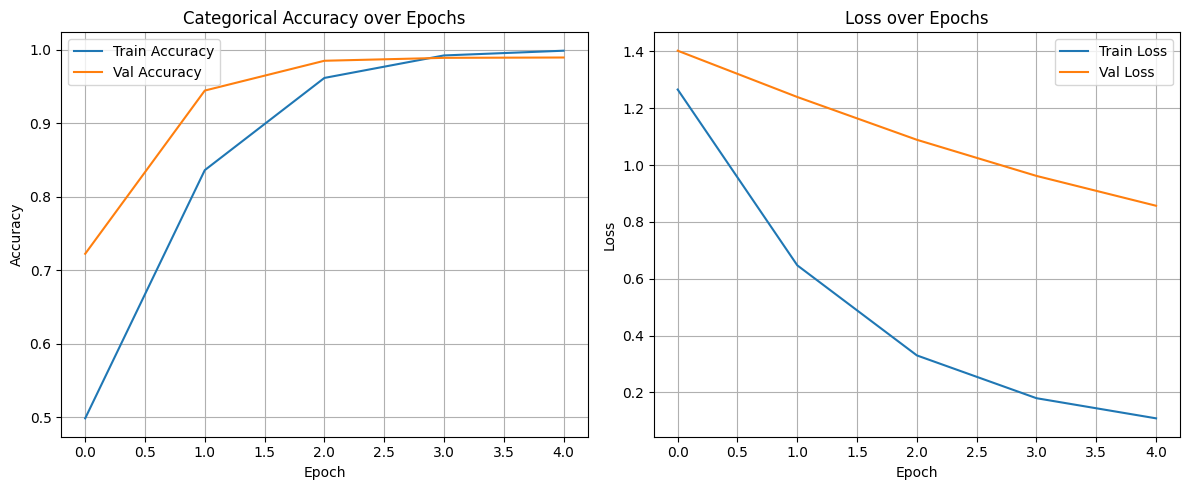

In [ ]:
# reconstructing the sequences from the probabilities
decoded_seq = np.argmax(recon_vectors,axis=-1)
decoded_seq_flat = decoded_seq.reshape(-1)
int_base = {1:'A',2:'T',3:'C',4:'G',0:'N'}
reconstructed_seq = ''.join([int_base.get(i,'N') for i in decoded_seq_flat])
print(len(reconstructed_seq))
print(reconstructed_seq[:150])
print(len(seq))
print(seq[:150])

# Remove the last pad_len characters from the reconstructed sequence
if pad_len > 0:
    cleaned_reconstructed_seq = reconstructed_seq[:-pad_len]
else:
    cleaned_reconstructed_seq = reconstructed_seq
print(len(cleaned_reconstructed_seq))
print(cleaned_reconstructed_seq[:150])
print(len(seq))
print(seq[:150])

# Save cleaned reconstructed sequence to file
recon_path = "/content/drive/My Drive/reconstructed_seq_cleaned.txt"

with open(recon_path, "w") as f:
    f.write(cleaned_reconstructed_seq)

print(f"Cleaned reconstructed sequence saved to: {recon_path}")

# Count mismatches
diff_count = sum(1 for a, b in zip(seq, cleaned_reconstructed_seq) if a != b)

# Accuracy
accuracy = (1 - diff_count / len(seq)) * 100

# Print results
print(f"Total characters compared: {len(seq)}")
print(f"Number of mismatches: {diff_count}")
print(f"Accuracy: {accuracy:.8f}%")


# Plot accuracy
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['cat_accuracy'], label='Train Accuracy')
plt.plot(history.history['val_cat_accuracy'], label='Val Accuracy')
plt.title('Categorical Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()